## Import

In [374]:
import h5py
import os
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import (accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, 
                             recall_score, confusion_matrix, precision_recall_curve, auc, 
                             average_precision_score)
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.feature_selection import mutual_info_classif
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score


from tensorflow.keras.layers import (GlobalAveragePooling2D, BatchNormalization, Input, Conv2D, 
                                     MaxPooling2D, UpSampling2D, Dense, Reshape, Flatten, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import warnings
warnings.filterwarnings("ignore")


## caricamento dati

In [375]:

file_path = "../CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )


h5_file_path = '../images_by_patient_final.h5'
loaded_class_images=[]

with h5py.File(h5_file_path, 'r') as h5_file:
    loaded_class_images = {key: np.array(h5_file[key]) for key in h5_file.keys()}

loaded_class_images= {int(key.split('_')[1]): images for key, images in loaded_class_images.items()}

print("Lunghezza array immagini: ", len(loaded_class_images))
print("Shape immagini primo paziente: ", loaded_class_images[0].shape)
print("Shape immagini secondo paziente: ", loaded_class_images[1].shape)




Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]
Lunghezza array immagini:  129
Shape immagini primo paziente:  (28, 64, 64)
Shape immagini secondo paziente:  (

## encoder

### righe filtrate per area

In [425]:
import zipfile
import pandas as pd
import numpy as np

# Percorso del file .npy
# Percorso del file .npy
file_path = "../indici_aree/aree_07.npy"
arraytuple = np.load(file_path)

# Converti il primo elemento di ogni tupla in int
arraytuple = [(int(t[0]), t[1], t[2]) for t in arraytuple]

# Percorso del primo file zip contenente il CSV
#zip_file_path = "../CSV/2_5/GMP/EncodersNuoviPesiFullImage/INCRES_ALL_SLICES_NuoviPesi_FullImage.zip"

#zip_file_path = "/Users/alessiamenozzi/Desktop/VGG_ALL_SLICES_Imagenet_FullImage.zip"

#zip_file_path = "/Users/alessiamenozzi/Desktop/INCEPTION_ALL_SLICES_NuoviPesi_FullImage.zip"
#zip_file_path = "../CSV/2_5/GMP/EncodersImagenetRitagliata/VGG_ALL_SLICES_Imagenet_Ritagliata.zip"

zip_file_path = "../CSV/2_5/GMP/EncodersNuoviPesiRitagliata/INCEPTION_ALL_SLICES_NuoviPesi_Ritagliata.zip"

#zip_file_path = "../CSV/2_5/GMP/EncodersImagenetRitagliata/VGG_ALL_SLICES_Imagenet_Ritagliata.zip"
#zip_file_path = "../CSV/2_5/GMP/EncodersImagenetRitagliata/RESNET_ALL_SLICES_Imagenet_Ritagliata.zip"
#zip_file_path = "../CSV/2_5/GMP/EncodersImagenetRitagliata/INCEPTION_ALL_SLICES_Imagenet_Ritagliata.zip"

#zip_file_path = "../CSV/2_5/GMP/EncodersNuoviPesiFullImage/INCRES_ALL_SLICES_NuoviPesi_FullImage.zip"

# Apri il file zip e leggi il CSV direttamente dalla memoria
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Ottieni il nome del file CSV dentro lo zip
    csv_filename = zip_ref.namelist()[0]
    # Leggi il file CSV direttamente dalla memoria
    with zip_ref.open(csv_filename) as csv_file:
        data = pd.read_csv(csv_file)

# Ordina i pazienti in ordine crescente
arraytuple_sorted = sorted(arraytuple, key=lambda t: t[0])

# Crea un dizionario con le slice e le loro aree, raggruppate per paziente
patients_slices = {}
for t in arraytuple_sorted:
    patient_id = t[0]
    if patient_id not in patients_slices:
        patients_slices[patient_id] = []
    patients_slices[patient_id].append(t)

# Per ogni paziente, tieni solo le 5 slice con area maggiore
for patient_id in patients_slices:
    patients_slices[patient_id] = sorted(patients_slices[patient_id], key=lambda x: x[2], reverse=True)[:5]

# Ora creiamo una lista finale di tuple per i pazienti ordinati con le 5 slice maggiori
final_tuples = []
for patient_id in sorted(patients_slices):
    final_tuples.extend(patients_slices[patient_id])

# Filtra il DataFrame per mantenere solo le righe che corrispondono agli elementi di final_tuples
filtered_data = data[
    data.apply(lambda row: any((row['Patient'] == (t[0]) and row['Slice'] == t[1]) for t in final_tuples), axis=1)
]

# Percorso del secondo file zip contenente il secondo CSV
second_zip_file_path = "../CSV/GMP/EncodersAllSlices/Radiomica_Wavelet_25D.csv.zip"

# Apri il secondo file zip e leggi il CSV direttamente dalla memoria
with zipfile.ZipFile(second_zip_file_path, 'r') as zip_ref:
    # Ottieni il nome del file CSV dentro lo zip
    second_csv_filename = zip_ref.namelist()[0]
    # Leggi il file CSV direttamente dalla memoria
    with zip_ref.open(second_csv_filename) as second_csv_file:
        second_csv = pd.read_csv(second_csv_file)

# Controlla che gli indici delle slice di ogni paziente siano presenti nel secondo CSV
for patient_id in patients_slices:
    slices_in_first = [t[1] for t in patients_slices[patient_id]]
    slices_in_second = second_csv[second_csv['Paziente'] == patient_id]['Slice'].tolist()
    
    # Se uno degli indici di slice non è presente nel secondo CSV, stampa un errore
    if not set(slices_in_first).issubset(set(slices_in_second)):
        print(f"Errore: alcune slice del paziente {patient_id} non sono presenti nel secondo CSV.")
        exit()

# Creazione delle ultime variabili se il controllo è ok
filtered_patients = []

for patient_id in sorted(patients_slices):
    # Filtra i dati per il paziente specifico
    filtered_patient_data = filtered_data[filtered_data['Patient'] == patient_id]
    
    # Dopo aver filtrato per paziente, rimuovi le prime due colonne ('Patient' e 'Slice')
    filtered_patient_data = filtered_patient_data.drop(filtered_patient_data.columns[:2], axis=1)
    
    slices = []
    
    for _, slice_row in filtered_patient_data.iterrows():
        # Seleziona solo le colonne filtrate per ogni slice
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    
    filtered_patients.append(slices)

# Stampa per verificare che le prime due colonne siano state rimosse
print(filtered_patient_data.head())


      Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
2812   0.002336   0.000000   0.149324        0.0        0.0        0.0   
2813   0.000000   0.029027   0.177347        0.0        0.0        0.0   
2814   0.000000   0.162370   0.243550        0.0        0.0        0.0   
2815   0.000000   0.046260   0.032161        0.0        0.0        0.0   
2816   0.000000   0.018325   0.035638        0.0        0.0        0.0   

      Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_2038  \
2812   0.417244        0.0   0.050712        0.0  ...      0.002372   
2813   0.444946        0.0   0.056821        0.0  ...      0.000000   
2814   0.452084        0.0   0.079017        0.0  ...      0.000000   
2815   0.561143        0.0   0.098905        0.0  ...      0.000000   
2816   0.594330        0.0   0.103076        0.0  ...      0.000000   

      Feature_2039  Feature_2040  Feature_2041  Feature_2042  Feature_2043  \
2812      0.000000           0.0      0.101458    

### righe non filtrate

In [352]:
import zipfile
# Percorso del file zip
zip_file_path = "../CSV/EncodersAllSlices/RESNET50_ALL_SLICES.zip"

# Apri il file zip e leggi il CSV direttamente dalla memoria
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Ottieni il nome del file CSV dentro lo zip
    csv_filename = zip_ref.namelist()[0]  # Se c'è un solo file, puoi usare il primo
    # Leggi il file CSV direttamente dalla memoria
    with zip_ref.open(csv_filename) as csv_file:
        data = pd.read_csv(csv_file)

data = data.drop(data.columns[-1], axis=1)

# Filter columns that start with 'original' or 'dentro'
patients = []

for patient_id in loaded_patients:

    # Filter the data for the specific patient
    patient_data = data[data['Patient'] == patient_id]
    
    slices = []
    
    for _, slice_row in patient_data.iterrows():
        # Select only the filtered columns for each slice
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    
    patients.append(slices)


Colonne del DataFrame:
Index(['Patient', 'Slice', 'Feature_0', 'Feature_1', 'Feature_2', 'Feature_3',
       'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7',
       ...
       'Feature_2038', 'Feature_2039', 'Feature_2040', 'Feature_2041',
       'Feature_2042', 'Feature_2043', 'Feature_2044', 'Feature_2045',
       'Feature_2046', 'Feature_2047'],
      dtype='object', length=2050)


In [375]:
print(len(patients))
print(len(patients[0][0]))
print(len(patients[1]))
print(len(patients[2]))

129
2050
36
49


In [381]:
print(len(filtered_patients))
print(len(filtered_patients[0][0]))
print(len(filtered_patients[1]))
print(len(filtered_patients[2]))

129
2050
17
27


## radiomica


## nuovo codice giusto

In [225]:
import zipfile
import pandas as pd
import numpy as np

# Percorso del file .npy
file_path = "../indici_aree/aree_07.npy"
arraytuple = np.load(file_path)

# Converti il primo elemento di ogni tupla in int
arraytuple = [(int(t[0]), t[1], t[2]) for t in arraytuple]

# Percorso del file zip contenente il CSV
zip_file_path = "../CSV/GMP/EncodersAllSlices/Radiomica_Wavelet_25D.csv.zip"

# Apri il file zip e leggi il CSV direttamente dalla memoria
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    csv_filename = zip_ref.namelist()[0]  # Se c'è un solo file, puoi usare il primo
    with zip_ref.open(csv_filename) as csv_file:
        data = pd.read_csv(csv_file)

# Crea un dizionario con le slice e le loro aree, raggruppate per paziente
patients_slices = {}
for t in arraytuple:
    patient_id = t[0]
    if patient_id not in patients_slices:
        patients_slices[patient_id] = []
    patients_slices[patient_id].append(t)

# Per ogni paziente, tieni solo le 5 slice con area maggiore
for patient_id in patients_slices:
    patients_slices[patient_id] = sorted(patients_slices[patient_id], key=lambda x: x[2], reverse=True)[:5]

# Crea una lista di tuple finali per i pazienti ordinati con le 5 slice maggiori
final_tuples = []
for patient_id in sorted(patients_slices):
    final_tuples.extend(patients_slices[patient_id])

# Filtra il DataFrame per mantenere solo le righe che corrispondono agli elementi di final_tuples
filtered_data = data[
    data.apply(lambda row: any((row['Paziente'] == (t[0]) and row['Slice'] == t[1]) for t in final_tuples), axis=1)
]

# Filtra le colonne che iniziano con 'original' o 'dentro'
filtered_patients = []
for patient_id in loaded_patients:
    # Filtra i dati per il paziente specifico
    filtered_patient_data = filtered_data[filtered_data['Paziente'] == patient_id]
    
    # Rimuovi le prime due colonne ('Paziente' e 'Slice')
    filtered_patient_data = filtered_patient_data.drop(filtered_patient_data.columns[:2], axis=1)
    
    # Rimuovi le colonne che iniziano con "diagnostics"
    filtered_patient_data = filtered_patient_data.filter(regex='^(?!diagnostics).*')

    slices = []
    
    for _, slice_row in filtered_patient_data.iterrows():
        # Seleziona solo le colonne filtrate per ogni slice
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    
    filtered_patients.append(slices)

# Stampa per verificare che le colonne "diagnostics" siano state rimosse
print(filtered_patient_data.head())

      original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
5177                     0.670387                         30.390451   
5178                     0.646481                         31.754581   
5179                     0.606961                         33.766174   
5180                     0.558283                         35.566134   
5181                     0.558702                         36.113805   

      original_shape2D_MaximumDiameter  original_shape2D_MeshSurface  \
5177                         31.064449                         400.0   
5178                         32.249031                         432.0   
5179                         33.615473                         460.0   
5180                         34.985711                         485.0   
5181                         35.846897                         474.5   

      original_shape2D_MinorAxisLength  original_shape2D_Perimeter  \
5177                         20.373362                  117.396970   


### righe non filtrate

In [ ]:
# Load the data
file_path = "../CSV/EncodersAllSlices/Radiomica_Wavelet_25D.csv.zip"
data = pd.read_csv(file_path)

# Filter columns that start with 'original'
filtered_columns = [col for col in data.columns if col.startswith('original')]

patients = []

for patient_id in loaded_patients:

    # Filter the data for the specific patient
    patient_data = data[data['Paziente'] == patient_id]
    
    slices = []
    
    for _, slice_row in patient_data.iterrows():
        # Select only the filtered columns for each slice
        slice_features = slice_row[filtered_columns].tolist()
        
        # Check for NaN values in the slice, and only append if there are no NaNs
        if not any(np.isnan(value) for value in slice_features):
            slices.append(slice_features)
    
    patients.append(slices)

# Optional: Check if all slices with NaN were removed successfully
for i, patient in enumerate(patients):
    for j, slice_features in enumerate(patient):
        assert not any(np.isnan(value) for value in slice_features), f"NaN found in patient {i}, slice {j}"

print("All slices with NaN values have been removed.")


### righe per slice 0.5

In [ ]:
import zipfile
import pandas as pd

file_path = "../indici_aree/aree_05.npy"
arraytuple = np.load(file_path)

# Converti il primo elemento di ogni tupla in int
arraytuple = [(int(t[0]), t[1], t[2]) for t in arraytuple]

zip_file_path = "../CSV/EncodersAllSlices/Radiomica_Wavelet_25D.csv.zip"

# Apri il file zip e leggi il CSV direttamente dalla memoria
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Ottieni il nome del file CSV dentro lo zip
    csv_filename = zip_ref.namelist()[0]  # Se c'è un solo file, puoi usare il primo
    # Leggi il file CSV direttamente dalla memoria
    with zip_ref.open(csv_filename) as csv_file:
        data = pd.read_csv(csv_file)

# Filtra il DataFrame per mantenere solo le righe che corrispondono agli elementi di arraytuple
filtered_data = data[
    data.apply(lambda row: any((row['Paziente'] == (t[0]) and row['Slice'] == t[1]) for t in arraytuple), axis=1)
]

# Filter columns that start with 'original' or 'dentro'
filtered_patients = []

for patient_id in loaded_patients:
    # Filter the data for the specific patient
    filtered_patient_data = filtered_data[filtered_data['Paziente'] == patient_id]
    
    # Rimuovi le prime due colonne ('Paziente' e 'Slice')
    filtered_patient_data = filtered_patient_data.drop(filtered_patient_data.columns[:2], axis=1)
    
    # Rimuovi le colonne che iniziano con "diagnostics"
    filtered_patient_data = filtered_patient_data.filter(regex='^(?!diagnostics).*')

    slices = []
    
    for _, slice_row in filtered_patient_data.iterrows():
        # Select only the filtered columns for each slice
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    
    filtered_patients.append(slices)

# Stampa per verificare che le colonne "diagnostics" siano state rimosse
print(filtered_patient_data.head())


In [145]:
print(len(filtered_patients))
print(len(filtered_patients[0][0]))
print(len(filtered_patients[1]))
print(len(filtered_patients[2]))

129
474
17
27


## funzioni

In [6]:
## funzione per creare array da array di array
def continue_array(filtered_patients, labels):
    all_features = []
    for patient in filtered_patients:
        for image_features in patient:
            all_features.append(image_features)

    all_features_array = np.array(all_features)
    expanded_labels = []
    expanded_patient_ids = []

    for i in range(len(filtered_patients)):
        num_images = len(filtered_patients[i])
        expanded_labels.extend([labels[i]] * num_images)
        expanded_patient_ids.extend([loaded_patients[i]] * num_images)

    expanded_labels_array = np.array(expanded_labels)
    expanded_patient_ids_array = np.array(expanded_patient_ids)

    return all_features_array, expanded_labels_array, expanded_patient_ids_array


## funzioni per feature correlation
def filter_highly_correlated_features(df, corr, threshold=0.85):
    columns = np.full((corr.shape[0],), True, dtype=bool)
    removed_features = []

    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= threshold:
                if columns[j]:
                    columns[j] = False
                    removed_features.append(df.columns[j])

    return removed_features


def perform_correlation(z_train, y_train, numero = 32, threshold = 0.85):
    all_images, _, _= continue_array(z_train, y_train)

    df = pd.DataFrame(all_images, columns=[f'feature_{i}' for i in range(numero)])

    corr_matrix = df.corr()

    features_selected = filter_highly_correlated_features(df, corr_matrix, threshold)
    
    return features_selected

## funzione per rimuovere le features con p_value maggiore della treshold
def select_features_by_p_value(x_train_expanded, y_train_expanded, p_value_threshold=0.05):

    p_values = []
    num_features = x_train_expanded.shape[1]

    for i in range(num_features):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)

    p_values = np.array(p_values)

    selected_features_indices = np.where(p_values < p_value_threshold)[0]

    sorted_indices = selected_features_indices[np.argsort(p_values[selected_features_indices])]

    x_train_expanded = x_train_expanded[:, sorted_indices]

    return x_train_expanded, sorted_indices



## funzione per rimozione di features specifiche
def remove_features_from_patients(patients, features_to_remove):
    feature_indices_to_remove = [int(feature.split('_')[1]) for feature in features_to_remove]
    
    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.delete(image_features, feature_indices_to_remove, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))    

    return final_patients


## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=2000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## FEATURE SELECTION P_VALUE
# Seleziona e ordina le feature basate sui p-value con un test t di Student poi 
# ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

def p_value_feature_selection(x_train_expanded, y_train_expanded, num_features):
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna feature
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)


    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)
    sorted_indices = sorted_indices[:num_features]

    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## funzione per lasciare solo le features indicate per array di array
def keep_features_in_patients(patients, features_to_keep):

    feature_indices_to_keep = [int(feature) for feature in features_to_keep]

    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.take(image_features, feature_indices_to_keep, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))

    return final_patients


## funzione per lasciare solo le features indicate per array
def filter_patients_features(filtered_patients, selected_features):
    filtered_patients_selected = []
    
    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected




In [7]:
def classifierinitialization(classifier):
    if classifier == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif classifier == 'Logistic':
                            classi = LogisticRegression(random_state=42, max_iter=2000)
    elif classifier == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif classifier == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
    elif classifier == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation = 'logistic')
    elif classifier == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42, max_iter=2000)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'
                                )
    return classi

In [8]:
## funzione per effettuarr majority voting o mean su tutte le slice di un paziente, per passare da una predizione sulla slice
## alla predizione per il paziente

def prob_to_binary(predictions_proba, patient_scores, threshold, mode):
    final_predictionarray = []          
    
    if mode == 'MV':  # Majority Voting
        for p in predictions_proba:
            test_patient_predictions = []
            for proba in p:               
                predictions_binary = 1 if proba[0][1] > threshold else 0
                test_patient_predictions.append(predictions_binary)
            count_0 = np.sum(np.array(test_patient_predictions) == 0) 
            count_1 = np.sum(np.array(test_patient_predictions) == 1)                                   
            final_prediction = 0 if count_0 > count_1 else 1
            final_predictionarray.append(final_prediction)
    
    elif mode == 'Mean':  # Mean of probabilities
        for score in patient_scores:
            predictions_binary = 1 if score > threshold else 0
            final_predictionarray.append(predictions_binary)
    
    elif mode == 'Max':  # Maximum probability across both classes
        for p in predictions_proba:
            max_proba = None
            max_slice = None

            #print(f"for patient {p}")
            # Itera su ogni slice per trovare la massima probabilità (indipendentemente dalla classe)
            for proba in p:
                class_0_prob = proba[0][0]  # Probabilità della classe 0
                class_1_prob = proba[0][1]  # Probabilità della classe 1
                #print("class_0_prob ", class_0_prob )
                #print("class_1_prob ", class_1_prob , "\n")
                # Trova la probabilità massima tra entrambe le classi per ciascuna slice
                slice_max_proba = max(class_0_prob, class_1_prob)

                # Trova la slice con la probabilità massima
                if max_proba is None or slice_max_proba > max_proba:
                    max_proba = slice_max_proba
                    max_slice = proba  # Memorizza la slice con la probabilità massima

            # Ora usa la probabilità della classe 1 della slice con la probabilità massima per il confronto con la soglia
            predictions_binary = 1 if max_slice[0][1] > threshold else 0
            final_predictionarray.append(predictions_binary)




    return final_predictionarray



def classification_method(selector, alpha, classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, num_features, modePrediction, thresholds=np.arange(0.001, 0.501, 0.001), mode = "Val", selected_features= [0]):

    #print(features_test)
    if(mode == "Val"):
            selected_features = None 
            
            if num_features != len(x_train_expanded[0]) or alpha != 0:
                if selector == "lasso":
                    X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                    if(len(selected_features)==0):
                            return 0
                elif selector == "logistic": 
                    X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "mrmr":
                    X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "rf":
                    X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector=="p_value":
                    X_selected, selected_features= p_value_feature_selection(x_train_expanded,y_train_expanded, num_features)
                else:
                    print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                    return
                
                #features_test = filter_patients_features(features_test, selected_features)
                features_test = keep_features_in_patients(features_test, selected_features)
                #keep_features_in_patients
                #print(f"features_test {features_test}")
            else:
                X_selected = x_train_expanded
                selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection
            number_features = len(selected_features) 
        
            #smote = SMOTE(random_state=10) ##### aiuto!! tenerlo???

            #X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_expanded)
            #classifier.fit(X_resampled, y_resampled)
            classifier.fit(X_selected, y_train_expanded)

    if(mode=='features'):
        X_selected = x_train_expanded[:, selected_features]
        features_test = keep_features_in_patients(features_test, selected_features)
        number_features = len(selected_features)
        classifier.fit(X_selected, y_train_expanded)


    patient_scores=[]
    temp_array=[]

    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità
    
    

    best_f1_score = 0
    best_threshold = None
    best_prediction=[]
    
    # Valuta le performance utilizzando diverse threshold
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    ## se non viene specificato usi il parametro di default 
    ## viene calcolata la threshold che porta a un f1 migliore e effettuata la prediction con quella
    if(len(thresholds)!=1):
        for threshold in thresholds:
            binary_predictions = prob_to_binary(temp_array, patient_scores, threshold, modePrediction)
            f1 = f1_score(y_test, binary_predictions)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold
                #best_precision = precision_score(y_test, binary_predictions)
                #best_recall = recall_score(y_test, binary_predictions)
                best_prediction=binary_predictions

    else: ## qui vuol dire che è il set di test che usa la threshold migliore che viene passata dal validation
        best_threshold = thresholds

        best_prediction=prob_to_binary(temp_array, patient_scores, best_threshold, modePrediction)
        best_f1_score = f1_score(y_test, best_prediction)
        #best_precision = precision_score(y_test, best_prediction)
        #best_recall = recall_score(y_test, best_prediction)

    #print(f"La migliore threshold è {best_threshold} con f1score di {best_f1_score} e precision {best_precision} e recall {best_recall}.")
    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)

    #precision, recall, _ = precision_recall_curve(y_test, patient_scores) ## utili per ricostruire grafici
    pr_auc = average_precision_score(y_test, patient_scores)

    #fpr, tpr, _ = roc_curve(y_test, best_prediction)
    roc_auc= roc_auc_score(y_test, patient_scores)

    # Calcola la balanced accuracy
    bal_acc = balanced_accuracy_score(y_test, best_prediction)

    conf= confusion_matrix(y_test, best_prediction)


    best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': best_f1_score,
                    'accuracy': test_accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': best_threshold,
                    'balanced accuracy': bal_acc
                }
    
    return best_case

## split

In [426]:

# patients_train contiene il nome dei pazienti (5,12 etc)
# y_train contiene le labels
# features_train contiene array di array dove ogni paziente ha varie immagini rappresentate da n features

#patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.3, shuffle=False)

patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, filtered_patients, test_size=0.3, shuffle=False)

print("Number of train patients: ", len(features_train1))
print("Number of test patients: ", len(features_test))


print("Number of features for every image: ", len(features_train1[0][0]) )


Number of train patients:  90
Number of test patients:  39
Number of features for every image:  2048


In [427]:
### correlation 0.8
starting_features = len(features_train1[0][0])
features=perform_correlation(features_train1, y_train1, starting_features, 0.9)

final_patients_train1=remove_features_from_patients(features_train1, features)
final_patients_test=remove_features_from_patients(features_test, features)

print(f"correlation ha trovato {final_patients_train1[0].shape[1]} features\n")

### p-value 0.01
x_train_expanded1, y_train_expanded1, _ = continue_array(final_patients_train1, y_train1)
x_train_expanded1, sf= select_features_by_p_value(x_train_expanded1, y_train_expanded1, 0.05)
print(f"Scelte {len(sf)} features dal p_value\n")
print("x_train_expanded1", x_train_expanded1.shape)

final_patients_test=keep_features_in_patients(final_patients_test, sf)
final_patients_train1=keep_features_in_patients(final_patients_train1, sf)

print("final_patients_test", len(final_patients_test))
print("final_patients_train1", final_patients_train1[0].shape)

patients_train1 = np.array(patients_train1)

correlation ha trovato 1270 features

Scelte 505 features dal p_value

x_train_expanded1 (450, 505)
final_patients_test 39
final_patients_train1 (5, 505)


In [443]:
alpha_inc = np.linspace(0.0007, 0.006, 30).tolist() ## RANGE PER RESNET e INCEPETION

alpha_vgg = np.linspace(0.005, 0.5, 30).tolist() ## RANGE PER VGG

alpha_rad = np.linspace(0.05, 3, 30).tolist() ## range per radiomica

alpha_res_inc_1C = np.linspace(0.08, 0.5, 30).tolist() 
alpha_vgg_1C = np.linspace(7, 40, 30).tolist() 

alpha_inc_2C = np.linspace(0.0009, 0.03, 30).tolist() 
alpha_res_fullimage_new_norm= np.linspace(0.006, 0.05, 30).tolist() ### QUELLO DEL 2D PER OTTENERE LE COMBINAZIONE 2C RESNET
alpha_res_2C = np.linspace(0.01, 0.06, 30).tolist() 
alpha_rad=np.linspace(0.04, 1, 30).tolist()+np.linspace(1, 30, 30).tolist()

alpha_res_fullimage_new_norm= np.linspace(0.006, 0.05, 30).tolist()

alpha_res_2B_2_5= np.linspace(0.002, 0.03, 30).tolist()
alpha_incres_2B_2_5= np.linspace(0.001, 0.006, 20).tolist() + np.linspace(0.006, 0.02, 10).tolist()

####1B
alpha_vgg_1B_2_5 = np.linspace(0, 0.005, 10)
alpha_inc_1B_2_5 = np.linspace(0.04, 0.4, 30)
alpha_res_1B_2_5 = np.linspace(0.2, 0.6, 30)

### 2C
alpha_incres_2C_2_5= np.linspace(0.002, 0.01, 20).tolist() + np.linspace(0.01, 0.03, 10).tolist() 

## 2B 
alpha_inc_2B_2_5= np.linspace(0.0007, 0.002, 20).tolist() + np.linspace(0.002, 0.01, 20).tolist() 

alpha_values=alpha_inc_2B_2_5


classifiers=['RandomForest', 'Logistic', 'XgBoost',  'SVM', 'ensemble', 'MLP']
#classifiers=['RandomForest']
selectors=['lasso', 'rf', 'mrmr', 'logistic']
#selectors=['lasso']
modes=['Max','Mean','MV']



## Loop results_val e test

In [444]:
template_dict = {
               'fold'
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'best_precision': None,
                'best_recall': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'selected_features': [],
                'mode': None,
                'balanced accuracy': None
            }


results_val_others = [template_dict.copy() for _ in range(50000)]
results_val_others.append(template_dict.copy())

results_val_lasso = [template_dict.copy() for _ in range(50000)]
results_val_lasso.append(template_dict.copy())


limit=30

smote = SMOTE(random_state=10)
 
k=0

n_folds=5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=4)



In [445]:
for fold_idx, (train_index, val_index) in enumerate(skf.split(final_patients_train1, y_train1)):
   
    print("Starting with fold:", fold_idx)

    y_train, y_val = y_train1[train_index], y_train1[val_index]
    patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]
    
    final_patients_train = [final_patients_train1[i] for i in train_index]
    final_patients_val = [final_patients_train1[i] for i in val_index]
    
    
    x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

    x_train_expanded, y_train_expanded = smote.fit_resample(x_train_expanded, y_train_expanded)

    for mode in modes:
        print("Starting with mode:", mode)
        for i, classifier in enumerate(classifiers):
                print("Starting with classifier:", classifier)
                for j, selector in enumerate(selectors):
                    print("Starting with selector:", selector)

                    if(selector=='lasso'):

                        for alpha in alpha_values:
                        
                            classi= classifierinitialization(classifier)
                            
                            best_case_val = classification_method(
                                   selector, alpha, classi, x_train_expanded, y_train_expanded, 
                                   patients_val, y_val, final_patients_val, 0, mode, thresholds=0.5
                              )
                            
                            #print(f"for {alpha} found {best_case_val['num_features']} ")
                             
                            if((best_case_val==0) or  (best_case_val['num_features']> limit)):
                                best_case_val=template_dict
                                best_case_val['balanced accuracy'] = 0
                                best_case_val['accuracy'] = 0
                                best_case_val['f1'] = 0
                                best_case_val['roc_auc'] = 0
                                best_case_val['pr_auc'] = 0
                                best_case_val['selected_features'] = [0]
                                best_case_val['num_features'] = 0
                                best_case_val['confusion_matrix'] = 0
                            

                            #print(f"for {alpha} found {best_case_val['num_features']} ")
                            
                            results_val_lasso[k] = {
                                                'fold': fold_idx,
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': alpha,
                                                'mode': mode,
                                                'num_features': best_case_val['num_features'],
                                                'selected_features': best_case_val['selected_features'],
                                                'pr_auc': best_case_val['pr_auc'],
                                                'roc_auc': best_case_val['roc_auc'],
                                                'f1': best_case_val['f1'],
                                                'accuracy': best_case_val['accuracy'],
                                                'confusion_matrix': best_case_val['confusion_matrix'],
                                                'balanced accuracy': best_case_val['balanced accuracy'],
                                                }

                            k = k + 1

                    else:
                        limit=30
                        for t in range(2, limit):
                                classi= classifierinitialization(classifier)

                                best_case_val = classification_method(
                                   selector, 0, classi, x_train_expanded, y_train_expanded, 
                                   patients_val, y_val, final_patients_val, t, mode, thresholds=0.5
                              )
                        
                                    
                                results_val_others[k] = {
                                                'fold': fold_idx,
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': 0,
                                                'mode': mode,
                                                'num_features': t,
                                                'selected_features': best_case_val['selected_features'],
                                                'pr_auc': best_case_val['pr_auc'],
                                                'roc_auc': best_case_val['roc_auc'],
                                                'f1': best_case_val['f1'],
                                                'accuracy': best_case_val['accuracy'],
                                                'confusion_matrix': best_case_val['confusion_matrix'],
                                                'balanced accuracy': best_case_val['balanced accuracy'],
                                }

                                k = k + 1

Starting with fold: 0
Starting with mode: Max
Starting with classifier: RandomForest
Starting with selector: lasso
for 0.0007 found 36 
for 0.0007684210526315789 found 32 
for 0.0008368421052631579 found 31 
for 0.0009052631578947369 found 31 
for 0.0009736842105263158 found 30 
for 0.0010421052631578948 found 29 
for 0.0011105263157894737 found 25 
for 0.0011789473684210526 found 22 
for 0.0012473684210526316 found 21 
for 0.0013157894736842105 found 19 
for 0.0013842105263157894 found 17 
for 0.0014526315789473684 found 14 
for 0.0015210526315789473 found 13 
for 0.0015894736842105264 found 13 
for 0.0016578947368421052 found 13 
for 0.0017263157894736843 found 12 
for 0.001794736842105263 found 12 
for 0.0018631578947368422 found 11 
for 0.001931578947368421 found 10 
for 0.002 found 10 
for 0.002 found 10 
for 0.0024210526315789475 found 8 
for 0.002842105263157895 found 8 
for 0.003263157894736842 found 7 
for 0.00368421052631579 found 7 
for 0.004105263157894737 found 5 
for 0.00

## dizionari

### salvo

In [447]:
import pickle
with open('/Users/alessiamenozzi/Desktop/dizionari 2.5/results_val_lasso_INC2B', 'wb') as pickle_file:
    pickle.dump(results_val_lasso, pickle_file)

with open('/Users/alessiamenozzi/Desktop/dizionari 2.5/results_val_others_INC2B', 'wb') as pickle_file:
    pickle.dump(results_val_others, pickle_file)


In [409]:
# Supponendo che results_others sia una lista di dizionari
results_val_others = [item for item in results_val_others if (item.get('num_features') != 1 and item.get('num_features') != 2 and item.get('num_features') != 3)]


### apro

In [291]:
import pickle
with open('/Users/alessiamenozzi/Desktop/dizionari 2.5/results_val_lasso_RESNET2C', 'rb') as file:
    results_val_lasso = pickle.load(file)

with open('/Users/alessiamenozzi/Desktop/dizionari 2.5/results_val_others_RESNET2C', 'rb') as file:
    results_val_others = pickle.load(file)

## valutazione migliori

In [448]:
#results_test_lasso = [entry for entry in results_test_lasso if entry['classifier'] is not None]
#print(f"Filtered results_test_lasso: {len(results_test_lasso)} entries remaining")
results_val_lasso= [entry for entry in results_val_lasso if entry['selector'] is not None]
print(f"Filtered results_val_lasso: {len(results_val_lasso)} entries remaining")
#results_test_others = [entry for entry in results_test_others if entry['classifier'] is not None]
#print(f"Filtered results_test_others: {len(results_test_others)} entries remaining")
results_val_others = [entry for entry in results_val_others if entry['selector'] is not None]
print(f"Filtered results_val_others: {len(results_val_others)} entries remaining")

Filtered results_val_lasso: 3600 entries remaining
Filtered results_val_others: 7560 entries remaining


### sorting dei risultati

In [449]:
import statistics

num_features_range = list(range(2, 30))

grid_results_others = {}
grid_results_lasso = {}

selectors = ['mrmr', 'rf', 'logistic']

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    #print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
            for mode in modes:
            #print(f"Sto iniziando selector {selector}")
                for num_features in num_features_range:
                        
                        # Filtra i risultati che corrispondono a questa combinazione di parametri
                        filtered_results=[]
                        for res in results_val_others:
                            ## qui filtro per num_features
                            if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features and res['mode']==mode):
                                filtered_results.append(res)
                    
                        if filtered_results:
                            f1_values = [res['f1'] for res in filtered_results]
                            balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                            roc_values=[res['roc_auc'] for res in filtered_results]

                            # Calcola le medie delle metriche
                            avg_f1 = sum(f1_values) / len(f1_values)
                            avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                            avg_roc = sum(roc_values) / len(roc_values)

                            # Calcola la deviazione standard delle metriche
                            std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                            std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                            std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                            # Memorizza i risultati medi e la deviazione standard di questa combinazione
                            grid_results_others[(classifier, selector, num_features, mode)] = {
                                'avg_f1': avg_f1,
                                'std_f1': std_f1,
                                'avg_balaccuracy': avg_balaccuracy,
                                'std_balaccuracy': std_balaccuracy,
                                'avg_roc_auc': avg_roc,
                                'std_roc_auc': std_roc_auc
                            }



## ORA PER LASSO
selectors = ['lasso']
for classifier in classifiers:
    #print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
        for mode in modes:
            #print(f"Sto iniziando selector {selector}")
            for alpha in alpha_values:
                    filtered_results = []
                    for res in results_val_lasso:
                        ## qui filtro per alpha
                        if (res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha and res['mode']==mode):
                            filtered_results.append(res)

                    if filtered_results:
                            f1_values = [res['f1'] for res in filtered_results]
                            balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                            roc_values=[res['roc_auc'] for res in filtered_results]

                            # Calcola le medie delle metriche
                            avg_f1 = sum(f1_values) / len(f1_values)
                            avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                            avg_roc = sum(roc_values) / len(roc_values)

                            # Calcola la deviazione standard delle metriche
                            std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                            std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                            std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                            # Memorizza i risultati medi e la deviazione standard di questa combinazione
                            grid_results_lasso[(classifier, selector, alpha, mode)] = {
                                'avg_f1': avg_f1,
                                'std_f1': std_f1,
                                'avg_balaccuracy': avg_balaccuracy,
                                'std_balaccuracy': std_balaccuracy,
                                'avg_roc_auc': avg_roc,
                                'std_roc_auc': std_roc_auc,
                            }


# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']),reverse=True)
sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']), reverse=True)

#sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_balaccuracy']),reverse=True)
#sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_balaccuracy']), reverse=True)


In [450]:
import functools

# Funzione di ordinamento personalizzata
def compare_items(item1, item2):
    balacc1 = item1[1]['avg_balaccuracy']
    balacc2 = item2[1]['avg_balaccuracy']
    
    # Se la differenza tra le balanced accuracies è minore di 0.001, confronta la ROC AUC
    if abs(balacc1 - balacc2) < 0.003:
        roc_auc1 = item1[1]['avg_roc_auc']
        roc_auc2 = item2[1]['avg_roc_auc']
        # Confronta la ROC AUC e ritorna -1, 0 o 1 per l'ordinamento
        if roc_auc1 > roc_auc2:
            return 1
        elif roc_auc1 < roc_auc2:
            return -1
        else:
            return 0
    else:
        # Altrimenti ordina per balanced accuracy
        if balacc1 > balacc2:
            return 1
        elif balacc1 < balacc2:
            return -1
        else:
            return 0

# Combina i risultati di others e lasso
sorted_results = sorted_results_others + sorted_results_lasso

# Utilizza cmp_to_key per usare la funzione di comparazione personalizzata
sorted_results = sorted(sorted_results, key=functools.cmp_to_key(compare_items), reverse=True)


### Mostro combinazioni

In [457]:
######### classificazione 2D

classifier2d = 'Logistic'
selector2d = 'rf'
num_features2d = 2

In [458]:

def calculate_metrics_for_folds(fold_indices, classifier, selector, num_features, modes, results_val_lasso, results_val_others):
    best_mode = None
    best_mean_bal_acc = -np.inf  # Imposto a -infinito per iniziare la ricerca del massimo
    best_std_bal_acc = np.inf  # Imposto a infinito per cercare la deviazione standard più bassa

    for mode in modes:
        balanced_accs = []
        roc_aucs = []

        # Controllo se 'lasso' è il selettore
        if selector == 'lasso':
            for result in results_val_lasso:
                if (result['classifier'] == classifier and
                    result['selector'] == selector and
                    result['num_features'] == num_features and
                    result['mode'] == mode and
                    result['fold'] in fold_indices):
                    
                    balanced_accs.append(result['balanced accuracy'])
                    roc_aucs.append(result['roc_auc'])
                    
        else:
            for result in results_val_others:
                if (result['classifier'] == classifier and
                    result['selector'] == selector and
                    result['num_features'] == num_features and
                    result['mode'] == mode and
                    result['fold'] in fold_indices):
                    
                    balanced_accs.append(result['balanced accuracy'])
                    roc_aucs.append(result['roc_auc'])

        if balanced_accs:
            # Calcolo delle medie e deviazioni standard
            mean_bal_acc = np.mean(balanced_accs)
            std_bal_acc = np.std(balanced_accs)
            
            print(f"Mode: {mode}")
            print(f"Balanced accuracy: Mean = {mean_bal_acc:.4f}, Std = {std_bal_acc:.4f}")
            print("---------------")
            
            # Controllo se è il miglior 'mode'
            if (mean_bal_acc > best_mean_bal_acc or 
                (mean_bal_acc == best_mean_bal_acc and std_bal_acc < best_std_bal_acc)):
                best_mean_bal_acc = mean_bal_acc
                best_std_bal_acc = std_bal_acc
                best_mode = mode
        else:
            print(f"No data found for mode: {mode}")
    
    # Ritorno il miglior mode
    if best_mode is not None:
        print(f"Best mode: {best_mode}")
        #print(f"Best Balanced Accuracy: Mean = {best_mean_bal_acc:.4f}, Std = {best_std_bal_acc:.4f}")
    else:
        print("No valid data to determine the best mode.")

    return best_mode

# Esempio di utilizzo
fold_idx = [0,1,2,3,4]
modes = ['Max', 'MV', 'Mean']

best_mode_fold2d = calculate_metrics_for_folds(fold_idx, classifier2d, selector2d, num_features2d, modes, results_val_lasso, results_val_others)
best_mode_fold2d='MV'


Mode: Max
Balanced accuracy: Mean = 0.5808, Std = 0.0798
---------------
Mode: MV
Balanced accuracy: Mean = 0.5683, Std = 0.0856
---------------
Mode: Mean
Balanced accuracy: Mean = 0.5583, Std = 0.0937
---------------
Best mode: Max


In [459]:
classi= classifierinitialization(classifier2d)
if(selector2d!='lasso'):
    
    best_case = classification_method(
                                        selector2d, 0, classi, x_train_expanded1, y_train_expanded1, 
                                        patients_test, y_test, final_patients_test, num_features2d , best_mode_fold2d, thresholds=0.5
                                    )
else:
    best_case = classification_method(
                                        selector2d, num_features2d, classi, x_train_expanded1, y_train_expanded1, 
                                        patients_test, y_test, final_patients_test, 0 , best_mode_fold2d, thresholds=0.5
                                    )



print("Metrics on the TEST set ON THE BEST 2D COMBINATION:")
print(f"Mode chosen by cheching the highest avg balacc: {best_mode_fold2d}")
print(f"Selected Features: {best_case['selected_features']} e sono {len(best_case['selected_features'])}")
print(f"ROC AUC: {best_case['roc_auc']}")
print(f"F1 Score: {best_case['f1']}")
print(f"Accuracy: {best_case['accuracy']}")
print(f"Balanced Accuracy: {best_case['balanced accuracy']}")
print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")

Metrics on the TEST set ON THE BEST 2D COMBINATION:
Mode chosen by cheching the highest avg balacc: MV
Selected Features: [274 395] e sono 2
ROC AUC: 0.8179012345679012
F1 Score: 0.0
Accuracy: 0.6923076923076923
Balanced Accuracy: 0.5
Confusion Matrix: 
[[27  0]
 [12  0]]


In [465]:
n=5
best_combinations = sorted_results[:n] ## mostrando le n migliori configurazioni

print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_combinations, start=1):

    classi= classifierinitialization(params[0])
    if(params[1]=='lasso'):
        best_case = classification_method(
                                    params[1], params[2], classi, x_train_expanded1, y_train_expanded1, 
                                    patients_test, y_test, final_patients_test, 0, params[3], thresholds=0.5
                                )
    
    else:
        best_case = classification_method(
                                    params[1], 0, classi, x_train_expanded1, y_train_expanded1, 
                                    patients_test, y_test, final_patients_test, params[2] , params[3], thresholds=0.5
                                )

    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    print(f"Num_features/alpha: {params[2]}")
    print(f"Mode : {params[3]}")

    print(f"Performance medie sul val set: \nROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']}), "f"Balanced Accuracy = {metrics['avg_balaccuracy']} (std = {metrics['std_balaccuracy']})")

    print("Metrics on the TEST set:")

    print(f"Selected Features: {best_case['selected_features']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Balanced Accuracy: {best_case['balanced accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")

    if (i==1):
           best_classifier1=params[0]
           best_selector1=params[1]
           best_param1=params[2]
           best_mode1=params[3]


Migliori 5 combinazioni di parametri:

#1:
Classifier: SVM
Selector: logistic
Num_features/alpha: 27
Mode : Max
Performance medie sul val set: 
ROC AUC = 0.6858024691358025 (std = 0.08347175004260139), Balanced Accuracy = 0.6872222222222223 (std = 0.08462767948964726)
Metrics on the TEST set:
Selected Features: [ 93   4  10   6  26 321  40 365  56 180 258   5 100  36  16 311 141 129
 334  54  85 257 477 174 403  76 237]
ROC AUC: 0.8117283950617283
F1 Score: 0.6666666666666666
Accuracy: 0.7948717948717948
Balanced Accuracy: 0.7592592592592593
Confusion Matrix: 
[[23  4]
 [ 4  8]]

#2:
Classifier: ensemble
Selector: lasso
Num_features/alpha: 0.009157894736842104
Mode : Max
Performance medie sul val set: 
ROC AUC = 0.688425925925926 (std = 0.07405815801230531), Balanced Accuracy = 0.6786111111111112 (std = 0.09310011371013197)
Metrics on the TEST set:
Selected Features: [ 16  49 257]
ROC AUC: 0.8395061728395062
F1 Score: 0.6923076923076923
Accuracy: 0.7948717948717948
Balanced Accuracy: 0

### features fisse test LOOP

In [466]:
from functools import reduce
from collections import Counter

best_classifier=best_classifier1
best_selector=best_selector1
best_num_features=best_param1
best_mode_fold=best_mode1


modes_selection=['Only the features in every fold', 'All the features', 'Features in at least 3 folds', 'Features in the best fold']
modes_selection=['All the features', 'Features in at least 3 folds', 'Features in the best fold']
modes_selection=['All the features', 'Features in the best fold']
modes_selection=['Features in at least 3 folds']

best_fold=None
best_mode=None
best_ba=0

balanced_acc=0
selected_features_array=[]

if (best_selector == 'lasso'):
    for res in results_val_lasso:
            if (res['classifier']==best_classifier and res['selector']==best_selector and res['alpha']==best_num_features and res['mode']==best_mode_fold):
                    selected_features_array.append(res['selected_features'])
                    if(res['balanced accuracy']>balanced_acc):
                        balanced_acc = res['balanced accuracy']

                        best_fold=res['fold']
else:
    for res in results_val_others:
        if (res['classifier']==best_classifier and res['selector']==best_selector and res['num_features']==best_num_features and res['mode']==best_mode_fold):
            selected_features_array.append(res['selected_features'])
            print(res)
            if(res['balanced accuracy']>balanced_acc):
                balanced_acc = res['balanced accuracy']
                best_fold=res['fold']
                

#print(selected_features_array)
for mode in modes_selection: 
    if (mode=='Only the features in every fold'):
        selected_features = reduce(np.intersect1d, selected_features_array)

    if(mode=='All the features'):
        selected_features = np.unique(np.concatenate(selected_features_array))

    if(mode=='Features in at least 3 folds'):
        all_elements = np.concatenate(selected_features_array)  # Unisci tutti gli array in uno
        element_counts = Counter(all_elements)  # Conta le occorrenze di ciascun elemento
        selected_features = np.array([key for key, count in element_counts.items() if count >= 3])
        print(selected_features)

    if(mode=='Features in the best fold'):
        selected_features = selected_features_array[best_fold]

    classi=classifierinitialization(best_classifier)
    best_case_test= classification_method(
                                        best_selector, 0, classi, x_train_expanded1, y_train_expanded1, 
                                        patients_test, y_test, final_patients_test, best_num_features, best_mode_fold, thresholds=0.5, mode='features', selected_features=selected_features
                                    )

    print(f" Mantenendo le features in questo modo: {mode}\n ha selezionato TROVATO DAL LOOP: {selected_features} e sono {len(selected_features)}")
    print(f"{best_classifier}, {best_selector}, {best_num_features}, {best_mode_fold}")
    print(f" Balanced Accuracy: {best_case_test['balanced accuracy']}")
    print(f" Accuracy: {best_case_test['accuracy']}")
    print(f" F1: {best_case_test['f1']}")
    print(f" roc_auc: {best_case_test['roc_auc']}")
    print(f" confusion matrix: {best_case_test['confusion_matrix']}\n")

    if(best_ba<best_case_test['balanced accuracy']):
        best_ba=best_case_test['balanced accuracy']
        best_mode=mode

print("Best mode is ", best_mode)


{'fold': 0, 'classifier': 'SVM', 'selector': 'logistic', 'alpha': 0, 'mode': 'Max', 'num_features': 27, 'selected_features': array([ 93,   4,  26, 365, 100, 200,  36,  40, 321, 260,   6,  10,  56,
        32, 129, 118, 311, 218, 180, 317, 246, 477, 153,  47, 204, 257,
        63]), 'pr_auc': 0.7544798951048951, 'roc_auc': 0.75, 'f1': 0.7, 'accuracy': 0.6666666666666666, 'confusion_matrix': array([[5, 5],
       [1, 7]]), 'balanced accuracy': 0.6875}
{'fold': 1, 'classifier': 'SVM', 'selector': 'logistic', 'alpha': 0, 'mode': 'Max', 'num_features': 27, 'selected_features': array([ 10,  93,   6, 141, 258,   4, 321, 180,  56, 118, 237, 365, 311,
        36,  49,  85, 265,  16,  40, 477, 334, 403,  28, 432, 338, 200,
        47]), 'pr_auc': 0.7521291208791209, 'roc_auc': 0.7875000000000001, 'f1': 0.8, 'accuracy': 0.8333333333333334, 'confusion_matrix': array([[9, 1],
       [2, 6]]), 'balanced accuracy': 0.825}
{'fold': 2, 'classifier': 'SVM', 'selector': 'logistic', 'alpha': 0, 'mode': 'M

### features fisse test combinazione 2d

In [462]:
best_classifier=classifier2d
best_selector=selector2d
best_num_features=num_features2d
best_mode_fold=best_mode_fold2d


modes_selection=['Features in at least 3 folds']

best_fold=None
best_mode=None
best_ba=0

balanced_acc=0
selected_features_array=[]

if (best_selector == 'lasso'):
    for res in results_val_lasso:
            if (res['classifier']==best_classifier and res['selector']==best_selector and res['alpha']==best_num_features and res['mode']==best_mode_fold):
                    selected_features_array.append(res['selected_features'])
                    if(res['balanced accuracy']>balanced_acc):
                        balanced_acc = res['balanced accuracy']

                        best_fold=res['fold']
else:
    for res in results_val_others:
        if (res['classifier']==best_classifier and res['selector']==best_selector and res['num_features']==best_num_features and res['mode']==best_mode_fold):
            selected_features_array.append(res['selected_features'])
            print(res)
            if(res['balanced accuracy']>balanced_acc):
                balanced_acc = res['balanced accuracy']
                best_fold=res['fold']
                

#print(selected_features_array)
for mode in modes_selection: 
    if (mode=='Only the features in every fold'):
        selected_features = reduce(np.intersect1d, selected_features_array)

    if(mode=='All the features'):
        selected_features = np.unique(np.concatenate(selected_features_array))

    if(mode=='Features in at least 3 folds'):
        all_elements = np.concatenate(selected_features_array)  # Unisci tutti gli array in uno
        element_counts = Counter(all_elements)  # Conta le occorrenze di ciascun elemento
        selected_features = np.array([key for key, count in element_counts.items() if count >= 3])
        print(selected_features)

    if(mode=='Features in the best fold'):
        selected_features = selected_features_array[best_fold]

    classi=classifierinitialization(best_classifier)
    if(selector!='lasso'):
        best_case_test= classification_method(
                                            best_selector, 0, classi, x_train_expanded1, y_train_expanded1, 
                                            patients_test, y_test, final_patients_test, best_num_features, best_mode_fold, thresholds=0.5, mode='features', selected_features=selected_features
                                        )
         

    print(f" Mantenendo le features in questo modo PER LA COMBINAZIONE 2D: {mode}\n ha selezionato: {selected_features} e sono {len(selected_features)}")
    print(f" Balanced Accuracy: {best_case_test['balanced accuracy']}")
    print(f" Accuracy: {best_case_test['accuracy']}")
    print(f" F1: {best_case_test['f1']}")
    print(f" roc_auc: {best_case_test['roc_auc']}")
    print(f" confusion matrix: {best_case_test['confusion_matrix']}\n")

    if(best_ba<best_case_test['balanced accuracy']):
        best_ba=best_case_test['balanced accuracy']
        best_mode=mode



{'fold': 0, 'classifier': 'Logistic', 'selector': 'rf', 'alpha': 0, 'mode': 'MV', 'num_features': 2, 'selected_features': array([274,  93]), 'pr_auc': 0.6405943627450981, 'roc_auc': 0.5, 'f1': 0.375, 'accuracy': 0.4444444444444444, 'confusion_matrix': array([[5, 5],
       [5, 3]]), 'balanced accuracy': 0.4375}
{'fold': 1, 'classifier': 'Logistic', 'selector': 'rf', 'alpha': 0, 'mode': 'MV', 'num_features': 2, 'selected_features': array([274, 236]), 'pr_auc': 0.7548347485847486, 'roc_auc': 0.75, 'f1': 0.631578947368421, 'accuracy': 0.6111111111111112, 'confusion_matrix': array([[5, 5],
       [2, 6]]), 'balanced accuracy': 0.625}
{'fold': 2, 'classifier': 'Logistic', 'selector': 'rf', 'alpha': 0, 'mode': 'MV', 'num_features': 2, 'selected_features': array([49,  1]), 'pr_auc': 0.6063666113298466, 'roc_auc': 0.625, 'f1': 0.5882352941176471, 'accuracy': 0.6111111111111112, 'confusion_matrix': array([[6, 4],
       [3, 5]]), 'balanced accuracy': 0.6125}
{'fold': 3, 'classifier': 'Logistic'

## Ensemble

In [ ]:
def train_classifier(classifier_type, mode, x_train_expanded, y_train_expanded, X_test, selected_features, patients_test):
        
        classifier = classifierinitialization(classifier_type)
        X_selected = x_train_expanded[:, selected_features]
        X_test = keep_features_in_patients(X_test, selected_features)
        classifier.fit(X_selected, y_train_expanded)

        patient_scores=[]
        temp_array=[]

        for x in range(len(patients_test)):
                patient_predictions = []
                patient_predictions1 = []
                r=len(features_test[x])
        for i in range(r):
            dato = X_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) 
        temp_array.append(patient_predictions) 
        
        best_prediction=prob_to_binary(temp_array, patient_scores, 0.5, mode)

        return best_prediction

    

In [ ]:
best_key, params = best_combinations[0]
classifier_type, selector_type, num_features, mode_prediction = best_key

y_pred_res1 = (classifier_type,mode_prediction, x_train_expanded1, y_train_expanded1, final_patients_test, selected_features,patients_test)
y_pred_inc1 = (classifier_type,mode_prediction, x_train_expanded1, y_train_expanded1, final_patients_test, selected_features,patients_test)
y_pred_incres = (classifier_type,mode_prediction, x_train_expanded1, y_train_expanded1, final_patients_test, selected_features,patients_test)

In [ ]:
#y_preds_combined = np.array([y_pred_res1, y_pred_inc1, y_pred_incres, y_pred_rad])

y_preds_combined = np.array([y_pred_res1, y_pred_inc1, y_pred_incres])

y_pred_hard = []

for i in range(y_preds_combined.shape[1]):
    predizioni_paziente = y_preds_combined[:, i]
    counts = np.bincount(predizioni_paziente)
    
    if len(counts) > 1 and counts.max() == counts.min():  # Caso di parit
        moda_paziente = 0
        print(f"entrato in {i}") # Imposta la predizione predefinita a 1 in caso di parit
    else:
        moda_paziente = counts.argmax()  # Altrimenti usa il valore della moda

    y_pred_hard.append(moda_paziente)

bal_acc_hard = balanced_accuracy_score(y_test, y_pred_hard)
f1_hard = f1_score(y_test, y_pred_hard)
accuracy_hard = accuracy_score(y_test, y_pred_hard)
conf_matrix_hard = confusion_matrix(y_test, y_pred_hard)

print("Hard Voting - Balanced Accuracy: ", bal_acc_hard)
print("Hard Voting - F1 Score: ", f1_hard)
print("Hard Voting - Accuracy: ", accuracy_hard)
print("Hard Voting - Confusion Matrix:\n", conf_matrix_hard)

## grafici

In [467]:
classifiers=['XgBoost',  'SVM', 'ensemble','RandomForest', 'Logistic', 'MLP']
selectors=['mrmr','rf', 'logistic', 'lasso']

best_results_class_selector_template={
    'classifier': None,
    'selector': None,
    'mode': None,
    'num_features/alpha': None,
    'avg_balaccuracy': None,
    'std_balaccuracy': None,
    'avg_roc_auc':None,
    'std_roc_auc': None,
}

best_results_class_selector = [best_results_class_selector_template.copy() for _ in range(23)]
best_results_class_selector.append(best_results_class_selector_template.copy())

i = 0
for classifier in classifiers:
    for selector in selectors:
        for params, metrics in sorted_results:
            if params[0] == classifier and params[1] == selector:
                best_results_class_selector[i]['classifier'] = params[0]
                best_results_class_selector[i]['selector'] = params[1]
                best_results_class_selector[i]['num_features/alpha'] = params[2]
                best_results_class_selector[i]['mode']=params[3]
                
                # Verifica se i valori sono tuple o scalari e assegna correttamente
                best_results_class_selector[i]['avg_balaccuracy'] = metrics['avg_balaccuracy'][0] if isinstance(metrics['avg_balaccuracy'], tuple) else metrics['avg_balaccuracy']
                best_results_class_selector[i]['std_balaccuracy'] = metrics['std_balaccuracy'][0] if isinstance(metrics['std_balaccuracy'], tuple) else metrics['std_balaccuracy']
                best_results_class_selector[i]['avg_roc_auc'] = metrics['avg_roc_auc'][0] if isinstance(metrics['avg_roc_auc'], tuple) else metrics['avg_roc_auc']
                best_results_class_selector[i]['std_roc_auc'] = metrics['std_roc_auc'][0] if isinstance(metrics['std_roc_auc'], tuple) else metrics['std_roc_auc']
                
                
                i += 1
                break

best_results_class_selector = [entry for entry in best_results_class_selector if entry['classifier'] is not None]
print(f"Filtered results_val_others: {len(best_results_class_selector)} entries remaining")

Filtered results_val_others: 24 entries remaining


In [29]:
metricaavg='avg_roc_auc'
metricastd='std_roc_auc'
metricanome= 'roc_auc'
labell='ROC'

In [468]:
metricaavg='avg_balaccuracy'
metricastd='std_balaccuracy'
metricanome= 'balanced accuracy'
labell='BA'

### heatmap val

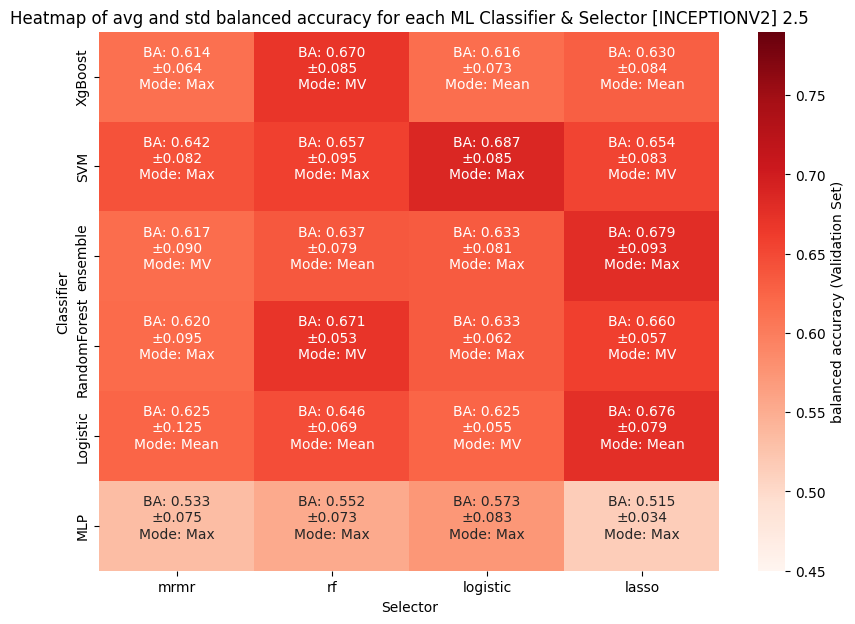

In [469]:

heatmap_data = pd.DataFrame(index=classifiers, columns=selectors)
annotations = pd.DataFrame(index=classifiers, columns=selectors)


for result in best_results_class_selector:
    classifier = result['classifier']
    selector = result['selector']
    
  
    if classifier is not None and selector is not None:

        avg_balaccuracy = result[metricaavg]
        std_balaccuracy = result[metricastd]
        mode = result['mode']
        num_features = result['num_features/alpha']
        
   
        heatmap_data.loc[classifier, selector] = avg_balaccuracy
        
        
        annotations.loc[classifier, selector] = (
            f"{labell}: {avg_balaccuracy:.3f}\n"
            f"±{std_balaccuracy:.3f}\n"
            f"Mode: {mode}\n"
            #f"Features: {num_features}"
        )

# Riempi i valori NaN con 0 (se necessario)
heatmap_data = heatmap_data.astype(float).fillna(0)

# Imposta il range fisso per i colori (modifica i valori in base alla tua scala preferita)
vmin = 0.45  # Il valore minimo per la mappatura dei colori
vmax = 0.79  # Il valore massimo per la mappatura dei colori, modifica in base ai tuoi dati

# Crea la heatmap con annotazioni e range fisso
plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=annotations, fmt="", cmap="Reds", 
            cbar_kws={'label': f'{metricanome} (Validation Set)'}, vmin=vmin, vmax=vmax)
plt.title(f"Heatmap of avg and std {metricanome} for each ML Classifier & Selector [INCEPTIONV2] 2.5")
plt.ylabel('Classifier')
plt.xlabel('Selector')
plt.show()



### heatmap test

In [19]:
### PER HEATMAP TEST
best_results_class_selector_template_test={
    'classifier': None,
    'selector': None,
    'mode': None,
    'balanced accuracy': None,
    'f1': None,
    'roc_auc':None,
    'accuracy': None,
    'selected_features': [],
    'confusion_matrix':[],
    'alpha': None,
    'num_features': None
}


best_results_class_selector_test = [best_results_class_selector_template_test.copy() for _ in range(23)]
best_results_class_selector_test.append(best_results_class_selector_template_test.copy())

i=0
for best_results_c_s in best_results_class_selector:
    print(best_results_c_s['classifier'])
    classi= classifierinitialization(best_results_c_s['classifier'])
    
    if(best_results_c_s['selector']=='lasso'):
        best_case_test = classification_method(
                                    best_results_c_s['selector'], best_results_c_s['num_features/alpha'], classi, x_train_expanded1, y_train_expanded1, 
                                    patients_test, y_test, final_patients_test, 0, best_results_c_s['mode'], thresholds=0.5
                                )
        best_results_class_selector_test[i]['alpha']=best_results_c_s['num_features/alpha']
    else:
        best_case_test = classification_method(
                                    best_results_c_s['selector'], 0, classi, x_train_expanded1, y_train_expanded1, 
                                    patients_test, y_test, final_patients_test,best_results_c_s['num_features/alpha'] , best_results_c_s['mode'], thresholds=0.5
                                )
        best_results_class_selector_test[i]['alpha']=0
        best_results_class_selector_test[i]['num_features']=best_results_c_s['num_features/alpha']
    
    best_results_class_selector_test[i]['classifier']=best_results_c_s['classifier']
    best_results_class_selector_test[i]['selector']=best_results_c_s['selector']
    best_results_class_selector_test[i]['mode']=best_results_c_s['mode']
    best_results_class_selector_test[i]['f1']=best_case_test['f1']
    best_results_class_selector_test[i]['balanced accuracy']=best_case_test['balanced accuracy']
    best_results_class_selector_test[i]['roc_auc']=best_case_test['roc_auc']
    best_results_class_selector_test[i]['accuracy']=best_case_test['accuracy']
    best_results_class_selector_test[i]['selected_features']=best_case_test['selected_features']
    best_results_class_selector_test[i]['confusion_matrix']=best_case_test['confusion_matrix']
    i=i+1




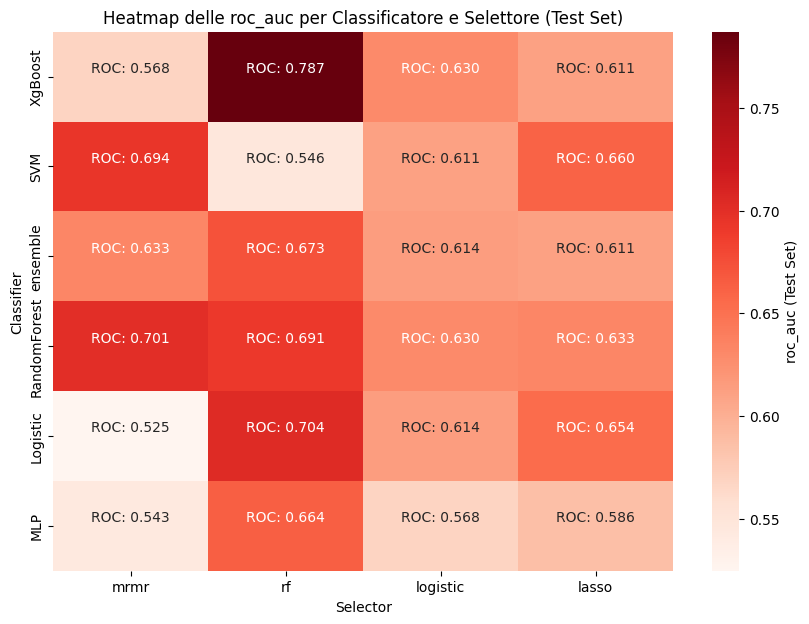

In [165]:

heatmap_data = pd.DataFrame(index=classifiers, columns=selectors)
annotations = pd.DataFrame(index=classifiers, columns=selectors)


for result in best_results_class_selector_test: ### per features NON FISSE
#for result in best_results_class_selector_test_featuresfisse: ## per features FISSE
    classifier = result['classifier']
    selector = result['selector']
    

    if classifier is not None and selector is not None:

        balaccuracy = result[metricanome]

        heatmap_data.loc[classifier, selector] = balaccuracy
        
        # Inserisci l'annotazione con la balanced accuracy, la deviazione standard, il mode e il numero di features
        annotations.loc[classifier, selector] = (
            f"{labell}: {balaccuracy:.3f}\n"
      
        )

# Riempi i valori NaN con 0 (se necessario)
heatmap_data = heatmap_data.astype(float).fillna(0)


# Crea la heatmap con Balanced Accuracy e annotazioni personalizzate
plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=annotations, fmt="", cmap="Reds", cbar_kws={'label': f'{metricanome} (Test Set)'})
plt.title(f"Heatmap delle {metricanome} per Classificatore e Selettore (Test Set)")
plt.ylabel('Classifier')
plt.xlabel('Selector')
plt.show()